# Bias-variance trade-off

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from sklearn import tree
from dtreeviz.trees import *

### Regression

In [2]:
# can't use too many records as model.score() will be average of many values
# which reduces variance; we're trying to highlight not hide that variance
df_rent = pd.read_csv("data/rent-ideal.csv", nrows=500)
X = df_rent[['bedrooms','bathrooms','latitude','longitude']]
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
0,3,1.5,40.7145,-73.9425
1,2,1.0,40.7947,-73.9667
2,1,1.0,40.7388,-74.0018
3,1,1.0,40.7539,-73.9677
4,4,1.0,40.8241,-73.9493


In [37]:
beds = [3, 2, 1, 1, 4, 4, 2, 1, 1, 4]
baths = [1.5, 1. , 1. , 1. , 1. , 2. , 1. , 2. , 1. , 2. ]
price = [3000, 5465, 2850, 3275, 3350, 7995, 3600, 5645, 1725, 5800]
X = np.stack((beds,baths),axis=1)
y = price
y

[3000, 5465, 2850, 3275, 3350, 7995, 3600, 5645, 1725, 5800]

In [3]:
ntrials = 20
n = len(X)
ntrain = int(n * 0.8)
ntest = n - ntrain
# leaf_sizes = list(range(1, n, n // n_hyperparameters))
leaf_sizes = [1,2,3,5,10,20,30,50,75,90,100,110,125,150,200,300,400,425,450,500]
all_train_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))
all_test_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))

print("Trial: ", end='')
for i in range(ntrials):
    print(f"{i} ", end='')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    train_scores = []
    test_scores = []
    for m in leaf_sizes:
        t = DecisionTreeRegressor(min_samples_leaf=m)
        t.fit(X_train, y_train)
        mae = mean_absolute_error(y_test, t.predict(X_test))
        s = t.score(X_test, y_test)
        train_s = t.score(X_train, y_train)
        test_scores.append(s)
#         test_scores.append(mae)
        train_scores.append(train_s)
#         print(f"samples / leaf = {m:5d}, score is {s:.2f}")
    all_test_scores[i] = test_scores
    all_train_scores[i] = train_scores

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [4]:
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
train_variances = np.std(all_train_scores, axis=0)
test_variances

array([0.09241334, 0.09640919, 0.09842971, 0.07339783, 0.06706968,
       0.06710533, 0.07173802, 0.07696312, 0.13126486, 0.07537685,
       0.06712585, 0.06413115, 0.06413115, 0.06413115, 0.07978478,
       0.01572811, 0.01572811, 0.01572811, 0.01572811, 0.01572811])

Text(0.5, 1.0, 'NYC Rent test error, stddev versus leaf size')

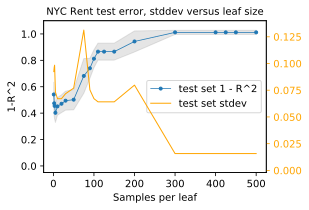

In [5]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)
# a = ax.errorbar(leaf_sizes, 1-test_scores, yerr=test_variances*3,
#                 uplims=True, lolims=True, elinewidth=.5,
#                 lw=1, label="test set 1 - R^2")

a = ax.plot(leaf_sizes, 1-test_means, lw=.75, marker='.', label="test set 1 - R^2")

plt.fill_between(leaf_sizes, 
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(leaf_sizes, test_variances, lw=1, label="test set stdev", c='orange')
ax2.yaxis.label.set_color('orange')
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylim(-0.002,0.14)

ax.set_xlabel("Samples per leaf")
ax.set_ylabel("1-R^2")
ax.set_ylim(-.05,1.1)
lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='center right')

ax.set_title("NYC Rent test error, stddev versus leaf size", fontsize=10)

### Classification

In [6]:
digits = load_digits()

df_digits = pd.DataFrame(data=digits.data)
df_digits['digit'] = digits.target
df_digits = df_digits.sample(n=500)
X = df_digits.drop('digit', axis=1)
y = df_digits['digit']

In [7]:
ntrials = 10
n_hyperparameters = 30
n = len(X)
ntrain = int(n * 0.8)
leaf_sizes = list(range(1, int(n*.6), n // n_hyperparameters))
all_train_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))
all_test_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))

for i in range(ntrials):
    print(f"Trial {i}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    train_scores = []
    test_scores = []
    for m in leaf_sizes:
        t = DecisionTreeClassifier(min_samples_leaf=m)
        t.fit(X_train, y_train)
        s = t.score(X_test, y_test)
        train_s = t.score(X_train, y_train)
        test_scores.append(s)
        train_scores.append(train_s)
#         print(f"samples / leaf = {m:5d}, score is {s:.2f}")
    test_scores = np.array(test_scores)
    train_scores = np.array(train_scores)
    all_test_scores[i] = test_scores
    all_train_scores[i] = train_scores

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


In [8]:
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
train_variances = np.std(all_train_scores, axis=0)
test_variances

array([0.0396106 , 0.03579106, 0.05473573, 0.05083306, 0.02773085,
       0.033     , 0.02765863, 0.028     , 0.04915282, 0.04237924,
       0.03905125, 0.03762978, 0.04006245, 0.01854724, 0.01854724,
       0.01854724, 0.01854724, 0.01854724, 0.01854724])

Text(0.5, 1.0, 'MNIST digits error, stddev versus leaf size')

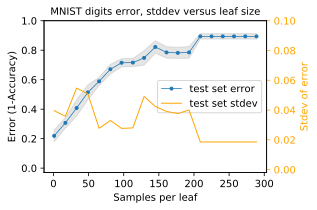

In [9]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)
a = ax.plot(leaf_sizes, 1-test_means, lw=.75, marker='.', label="test set error")

plt.fill_between(leaf_sizes,
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(leaf_sizes, test_variances, lw=1, label="test set stdev", c='orange')
ax2.yaxis.label.set_color('orange')
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylabel("Stdev of error")
ax2.set_ylim(-0.002,0.1)

ax.set_xlabel("Samples per leaf")
ax.set_ylabel("Error (1-Accuracy)")
ax.set_ylim(-.03,1.0)

lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='center right')

ax.set_title("MNIST digits error, stddev versus leaf size", fontsize=10)

## Error sources diagrams

Text(0.5, 1.0, 'Perfect $y = f(X) = (X-2)^2$ data')

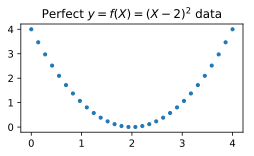

In [10]:
X = np.linspace(0,4,30)
y = (X-2)**2
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10)
ax.set_title("Perfect $y = f(X) = (X-2)^2$ data")

Text(0.5, 1.0, 'Inconsistent $y = f(X) = (X-2)^2$ data')

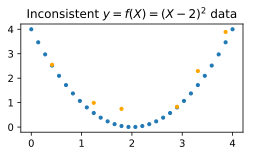

In [11]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10)
for i in [3,9,13,21,24,28]:
    ax.scatter([X[i]],[y[i]+np.random.rand()],s=10,c='orange')
ax.set_title("Inconsistent $y = f(X) = (X-2)^2$ data")

In [12]:
X = np.linspace(0,4,30)
y = (X-2)**2 + np.random.random(size=len(X))*1.5
y_ = (X-2)**2 + np.random.random(size=len(X))*1.5

Text(0.5, 1.0, 'Noisy $y = f(X) = (X-2)^2 + \\epsilon$ data')

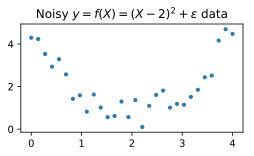

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.set_title("Noisy $y = f(X) = (X-2)^2 + \epsilon$ data")

Text(0.5, 1.0, 'Underfit (shallow) decision tree')

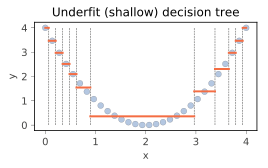

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
t = rtreeviz_univar(ax,
                    X, (X-2)**2,
                    max_depth=4,
                    feature_name='x',
                    target_name='y',
                    fontsize=10,
                    colors={'scatter_edge': 'black'},
                   show=['splits'])
ax.set_title("Underfit (shallow) decision tree")

Text(0.5, 1.0, 'Noisy data (shallow) decision tree')

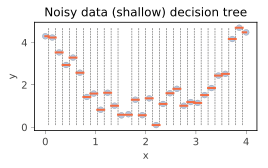

In [15]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
t = rtreeviz_univar(ax,
                    X, y,
                    max_depth=10,
                    feature_name='x',
                    target_name='y',
                    fontsize=10,
                    colors={'scatter_edge': 'black'},
                   show=['splits'])
ax.set_title("Noisy data (shallow) decision tree")

Text(0.5, 1.0, 'Underfit')

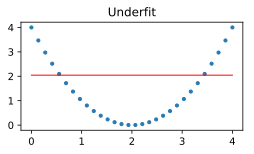

In [16]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,(X-2)**2,s=10,c='#2679B2')
ax.plot([0,4], [np.mean(y)]*2, c='red',lw=1)
ax.set_title("Underfit")

Text(0.5, 1.0, 'Underfit')

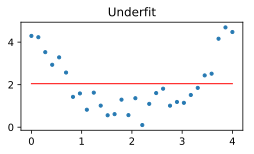

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot([0,4], [np.mean(y)]*2, c='red',lw=1)
ax.set_title("Underfit")

Text(0.5, 1.0, 'Balanced model')

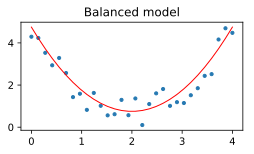

In [18]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot(X,(X-2)**2+.75, c='red',lw=1)
ax.set_title("Balanced model")

Text(0.5, 1.0, 'Overfit model')

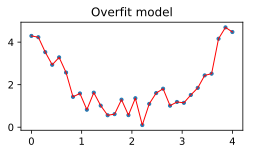

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot(X,y,c='red',lw=1)
ax.set_title("Overfit model")

In [20]:
# do overfitting on non-noisy data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

X = np.linspace(0,4,30)
y = (X-2)**2 + np.random.random(size=len(X))

model = Pipeline([('poly', PolynomialFeatures(degree=27)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
#y = 3 - 2 * X + X ** 2 - X ** 3
model = model.fit(X[:, np.newaxis], y)
coef = model.named_steps['linear'].coef_
coef

array([ 4.52146578e-01,  4.74845619e-01,  3.58976499e-01,  2.93971195e-01,
        2.42201605e-01,  1.88655397e-01,  1.26322154e-01,  5.39017213e-02,
       -2.33237871e-02, -9.23008597e-02, -1.33277000e-01, -1.26056729e-01,
       -6.30889005e-02,  3.42643265e-02,  1.09832881e-01,  9.84454903e-02,
       -9.00996939e-03, -1.09924298e-01, -5.94634077e-02,  9.68227917e-02,
        6.04797984e-02, -1.37494676e-01,  9.27876555e-02, -3.45392005e-02,
        7.88524302e-03, -1.10588162e-03,  8.79819392e-05, -3.05347484e-06])

Text(0.5, 1.0, 'Overfit degree 27 polynomial on noisy data')

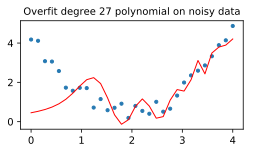

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
#ax.plot(X,coef[0]+coef[1]*X + coef[2]*X**2 + coef[3]*X**3)
ax.plot(X,model.predict(X.reshape(-1,1)), c='red', lw=1)
ax.set_title("Overfit degree 27 polynomial on noisy data", fontsize=10)

Text(0.5, 1.0, 'Ensemble of overfit models')

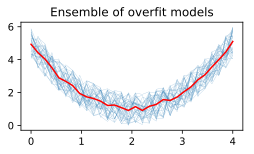

In [38]:
X = np.linspace(0,4,30)
ntrials = 35
fig, ax = plt.subplots(1,1, figsize=(4,2))
ys = np.zeros(shape=(ntrials,len(X)))
for i in range(ntrials):
    y = (X-2)**2 + np.random.random(size=len(X))*2.0
    ys[i] = y
#    ax.scatter(X,y,s=.25,c='#2679B2')
    ax.plot(X,y,c='#2679B2',lw=.25, alpha=.5)

y_avg = np.mean(ys,axis=0)
#ax.scatter(X,y,s=.5,c='#2679B2')
ax.plot(X,y_avg,c='red',lw=1.5)

#ax.set_title("Overfit model")
ax.set_title("Ensemble of overfit models")